Homework notebook for MLOps student course - Lab 2

Imports

In [44]:
import os
import time
import pandas as pd
import duckdb
import psycopg
import urllib.request
import matplotlib.pyplot as plt
import glob
import plotly.express as px


Data Loading and creating distances and distances_long table

In [12]:
db = duckdb.connect('data/homework.db')

#Station table
db.sql(
    """
    CREATE OR REPLACE TABLE stations AS
    Select *
    From read_csv('data/stations-2023-09.csv',header=true, auto_detect=true)
    """
)

column_names = db.read_csv('data/tariff-distances-2022-01.csv', header=True).columns

new_names = ['start_station'] + list(column_names[1:])

#Distances stations table and distances_long table 
db.sql("""
       CREATE OR REPLACE TABLE distances AS
        SELECT *
        FROM read_csv(
        'data/tariff-distances-2022-01.csv',
        header=true,
        names = ?
    );""",
    params=[new_names]
) 

#Unpivot tables
db.sql("""
       CREATE OR REPLACE TABLE distances_long AS
       Select *
       From(
       UNPIVOT distances
       ON * EXCLUDE(start_station)
       INTO
       NAME end_station
       VALUE distance)
       WHERE start_station != end_station;
       """)

OLTP distruptions table

In [15]:
#Create one distruptions file

disruption_files = []

for path in os.listdir('data'):
    if path.startswith('disruptions-'):
        disruption_files.append(os.path.join('data', path))
        
disruption_files.sort()

df_list = []
for file in disruption_files:
    df = pd.read_csv(file)
    df_list.append(df)
    
combined_df = pd.concat(df_list, ignore_index=True)
output_file = os.path.join('data', 'disruptions.csv')
combined_df.to_csv(output_file, index=False)

print(output_file)
print(len(combined_df))



data\disruptions.csv
55864


In [18]:
#distruptions table 2011-2024
db.execute("""CREATE OR REPLACE TABLE disruptions AS 
            FROM read_csv_auto('data/disruptions.csv');""")
print('disruptions rows count:', db.execute(
    'SELECT COUNT(*) FROM disruptions').fetchone()[0])

#After doing everything, 

disruptions rows count: 55864


parquet services table

In [22]:
#gz to csv format
#WARNING: ONLY 2023-2025.09 files are present (out of memory issue with all files)

file_pattern = os.path.join('data', 'services-*.csv.gz')

gz_files = sorted(glob.glob(file_pattern))

gz_df_list = []

for gz_file in gz_files:
    print(f'Processing file: {gz_file}')
    df = pd.read_csv(gz_file, compression='gzip', low_memory=False)
    gz_df_list.append(df)
    
    
gz_combined_df = pd.concat(gz_df_list, ignore_index=True)
output_gz_file = os.path.join('data', 'services.csv')
gz_combined_df.to_csv(output_gz_file, index=False)

print(output_gz_file)
print(len(gz_combined_df))

Processing file: data\services-2023.csv.gz
Processing file: data\services-2024.csv.gz
Processing file: data\services-2025-01.csv.gz
Processing file: data\services-2025-02.csv.gz
Processing file: data\services-2025-03.csv.gz
Processing file: data\services-2025-04.csv.gz
Processing file: data\services-2025-05.csv.gz
Processing file: data\services-2025-06.csv.gz
Processing file: data\services-2025-07.csv.gz
Processing file: data\services-2025-08.csv.gz
Processing file: data\services-2025-09.csv.gz
data\services.csv
59704152


In [26]:
#from csv to parquet

db.execute("""COPY (SELECT * FROM 'data/services.csv') 
            TO 'data/services.parquet' 
            (FORMAT parquet, COMPRESSION zstd);""")

db.execute("""CREATE OR REPLACE TABLE services AS 
            SELECT * FROM read_parquet('data/services.parquet')""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [25]:
print('services rows:', db.execute('SELECT COUNT(*) FROM services').fetchone()[0])


services rows: 59704152


### QUERIES 

1. How many trains departed from Amsterdam Central station overall?

In [ ]:
result1 = db.execute("""SELECT COUNT(*) FROM services 
    WHERE "Stop:Station name" = 'Amsterdam Centraal' 
    AND "Stop:Arrival time" IS NULL;
    """).fetchone()[0]

#2023-2025.09 only!!!!!
print('Number of trains departed from Amsterdam Central station:', result1)

Number of trains departed from Amsterdam Central station: 391503


2. Calculate the average arrival delay of different service types (Service:Type). Order results descending by average delay.

In [ ]:
result2 = db.execute("""
    SELECT "Service:Type", AVG("Stop:Arrival delay") as avg_delay
    FROM services
    GROUP BY "Service:Type"
    ORDER BY avg_delay DESC;
    """).fetchall()

#2023-2025.09 only!!!!!
for row in result2:
    print(f"{row[0]}: {row[1]}")

Stoomtrein: 15.76923076923077
European Sleeper: 14.730917608156517
Nightjet: 9.111268626153798
Eurostar: 7.602453774756998
ICE International: 6.875325079271822
Int. Trein: 6.0
Thalys: 5.902070574511519
Nachttrein: 3.6171527434503212
Extra trein: 2.892067290261765
Intercity direct: 2.6388921829147507
Eurocity Direct: 2.324380800196669
EuroCity: 1.944202342337881
Sneltrein: 1.5219612997715175
Intercity: 1.1999076909793078
Sprinter: 0.7994739491067087
Speciale Trein: 0.7779269111097553
Stoptrein: 0.7424193350437579
Snelbus ipv trein: 0.010315677555949568
Stopbus ipv trein: 0.0003311231617129031
Snelbus i.p.v. trein: 0.0
Tram ipv trein: 0.0
Belbus ipv trein: 0.0
stoptrein: 0.0
Bus: 0.0
Metro ipv trein: 0.0
Metro i.p.v. trein: 0.0
Belbus: 0.0
Stopbus i.p.v. trein: 0.0
Taxibus ipv trein: 0.0


3. What was the most common disruption cause in different years? MODE function may be useful.


In [ ]:
result3 = db.execute("""
       SELECT EXTRACT(YEAR FROM start_time) as year, 
              MODE(statistical_cause_en) as most_common_cause,
              COUNT(*) as occurrences
       FROM disruptions
       GROUP BY year
       ORDER BY year;
       """).fetchall()

for row in result3:
    print(f"{int(row[0])}: {row[1]} ({row[2]} occurrences)")

2011: broken down train (1846 occurrences)
2012: points failure (2074 occurrences)
2013: points failure (2312 occurrences)
2014: broken down train (2484 occurrences)
2015: broken down train (2947 occurrences)
2016: broken down train (3031 occurrences)
2017: broken down train (4085 occurrences)
2018: broken down train (5190 occurrences)
2019: broken down train (5940 occurrences)
2020: broken down train (4450 occurrences)
2021: broken down train (4874 occurrences)
2022: broken down train (5499 occurrences)
2023: broken down train (5168 occurrences)
2024: broken down train (5964 occurrences)


4. How many trains started their overall service in any Amsterdam station?


In [ ]:
result4 = db.execute("""
    SELECT COUNT(DISTINCT "Service:RDT-ID") FROM services 
    WHERE "Stop:Station name" LIKE '%Amsterdam%' 
    AND "Stop:Arrival time" IS NULL;
    """).fetchone()[0]

#2023-2025.09 only!!!!!
print(f'Number of trains that started their service in any Amsterdam station {result4}:')

Number of trains that started their service in any Amsterdam station 464221:


5. What fraction of services was run to final destinations outside the Netherlands?

In [35]:
total_services = db.execute("""
    SELECT COUNT(DISTINCT "Service:RDT-ID") 
    FROM services;""").fetchone()[0]

outside_services = db.execute("""
    SELECT COUNT(DISTINCT s."Service:RDT-ID") 
    FROM services s 
    JOIN stations st ON s."Stop:Station code" = st.code 
    WHERE s."Stop:Departure time" IS NULL AND st.country != 'NL';
    """).fetchone()[0]


#2023-2025.09 only!!!!!
print(f'Fraction of services run to final destinations outside the Netherlands: {outside_services / total_services:.4f}')

Fraction of services run to final destinations outside the Netherlands: 0.0433


6. What is the largest distance between stations in the Netherlands (code NL)?

In [53]:
result6 = db.execute("""
    SELECT MAX(distance) AS max_distance_nl
        FROM distances_long
        JOIN stations ON (end_station = code)
        WHERE country ='NL'
    """).fetchone()[0]

print(f'Largest distance between stations in the Netherlands: {result6} km')

Largest distance between stations in the Netherlands: 99 km


7. Compare the average arrival delay between different train operators (Service:Company) on a bar plot. Sort them appropriately.


In [ ]:
result = db.execute("""
    SELECT "Service:Company" as company, AVG("Stop:Arrival delay") as avg_delay
    FROM services
    WHERE "Stop:Arrival time" IS NOT NULL
    GROUP BY "Service:Company"
    ORDER BY avg_delay DESC;
    """).fetchall()

df = pd.DataFrame(result, columns=['Company', 'Avg Delay'])
fig = px.bar(df, x='Company', y='Avg Delay', title='Average Arrival Delay by Train Operator')
#2023-2025.09 only!!!!!
fig.show()

8. How many services were disrupted in different years? Make a line plot.

In [49]:
result = db.execute("""
    SELECT EXTRACT(YEAR FROM start_time) as year, COUNT(DISTINCT rdt_id) as disrupted_services
    FROM disruptions
    GROUP BY year
    ORDER BY year;
    """).fetchall()

df = pd.DataFrame(result, columns=['Year', 'Disrupted Services'])
fig = px.line(df, x='Year', y='Disrupted Services', title='Number of Disrupted Services by Year')
fig.show()

9. What fraction of all services were cancelled (Service:Completely cancelled) in different years? Make a line plot.

<Axes: title={'center': 'Fraction of Completely Cancelled Services per Year'}, xlabel='Year', ylabel='Fraction of Cancelled Services'>

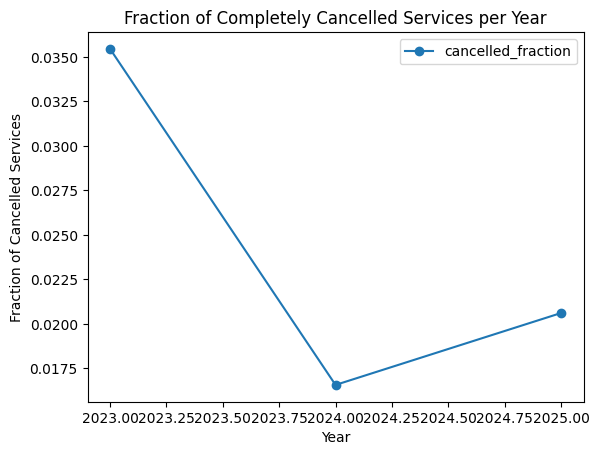

In [51]:
df = db.sql("""
SELECT 
    EXTRACT(YEAR FROM "Service:Date") AS year,
    AVG(CASE WHEN "Service:Completely cancelled" THEN 1.0 ELSE 0.0 END) AS cancelled_fraction
FROM services
GROUP BY year
ORDER BY year;
""").df()

df.plot.line(x='year', y='cancelled_fraction', title='Fraction of Completely Cancelled Services per Year',
                xlabel='Year', ylabel='Fraction of Cancelled Services', marker='o')

# 8. 

Create table station_connections, with columns Service:RDT-ID, start_station_code and end_station_code (pair of stations on a route), and distance between them. Note that you should deduplicate the data on station codes, so that every station pair appears only once. Create temporary tables, use a subquery, or any other similar techniques if necessary.

In [54]:
db.execute("""
    CREATE OR REPLACE TEMP VIEW service_segments AS
    SELECT 
        "Service:RDT-ID",
        "Stop:Station code" AS start_station_code,
        LEAD("Stop:Station code") OVER (
            PARTITION BY "Service:RDT-ID" 
            ORDER BY "Stop:Departure time" NULLS LAST
        ) AS end_station_code
    FROM services
    WHERE "Stop:Station code" IS NOT NULL
    """)

In [58]:
db.execute("""
    CREATE OR REPLACE TABLE station_connections AS
    SELECT DISTINCT
        ss.start_station_code,
        ss.end_station_code,
        dl.distance
    FROM service_segments ss
    JOIN distances_long dl ON 
        ss.start_station_code = dl.start_station 
        AND ss.end_station_code = dl.end_station
    WHERE ss.end_station_code IS NOT NULL
        AND dl.distance IS NOT NULL
    """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

What is the largest distance between a pair of stations?


In [59]:
result8 = db.execute("""
    SELECT start_station_code, end_station_code, distance
    FROM station_connections
    ORDER BY distance DESC
    LIMIT 1
    """).fetchone()

print(f'Largest distance between a pair of stations: {result8[0]} -> {result8[1]}: {result8[2]} km')

Largest distance between a pair of stations: PT -> GVC: 99 km


Plot a histogram of inter-station distances run by trains.


In [ ]:
df = pd.DataFrame(db.execute("""
    SELECT distance 
    FROM station_connections
    WHERE distance IS NOT NULL
    ORDER BY distance
    """).fetchall(), columns=['distance'])

fig = px.histogram(
    df, 
    x='distance', 
    nbins=50,
    title='Histogram of Inter-Station Distances',
    labels={'distance': 'Distance (km)', 'count': 'Frequency'}
)
fig.update_layout(
    xaxis_title='Distance (km)',
    yaxis_title='Number of Station Pairs'
)
fig.show()
